In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
# Check GPU
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#TRAIN DATA 匯入
a = pd.read_csv("./train.csv", index_col = 0)
b = pd.read_csv("./test.csv", index_col = 0)

y=a.pop('class')
print('train shape : ', a.shape)
print('test shape : ', b.shape)

train shape :  (108800, 9)
test shape :  (27200, 9)


In [4]:
dfAllData=pd.concat([a,b],ignore_index=False)
print('all data shape : ', dfAllData.shape)

all data shape :  (136000, 9)


In [5]:
cols=list(dfAllData.columns)
dfAllData.head(10)

,device_id,age,sex,browser,source,country,purchase_value,signup_time,purchase_time
user_id,,,,,,,,,
6b5aecb444b26,7a543b4bf3647,33,0,Safari,Ads,United States,48,2018-05-27 12:02:29,2018-08-19 14:09:55
f00edc3db68f0,c35ab03e7ff0f,26,1,Chrome,Direct,European Union,50,2018-06-06 08:09:12,2018-09-09 01:26:43
6f144a20b2e41,31a274c4b1d58,28,0,Chrome,Direct,United States,31,2018-03-29 18:24:17,2018-06-13 04:56:21
21db12c470157,74e7d74dbd61d,50,0,FireFox,Ads,United States,31,2018-06-18 02:49:33,2018-06-29 23:31:45
af1753dfd703c,b5f31ea91ae62,27,1,IE,SEO,United States,16,2018-01-31 18:26:38,2018-02-13 16:36:51
56ab6189b8cd6,43f6244c9dd95,24,1,FireFox,SEO,United States,86,2018-01-24 17:31:45,2018-05-05 23:54:07
7b8162369fc4f,97701c792782a,38,0,FireFox,Ads,NaN,28,2018-07-29 10:11:40,2018-10-13 11:28:04
8ffc72bf16576,c1ff42cc0d6d1,35,1,IE,SEO,Germany,21,2018-06-03 13:41:50,2018-08-11 06:37:01
095deac2caeeb,8164501b765d6,40,1,IE,Direct,Japan,48,2018-06-16 13:08:48,2018-08-16 09:46:35


In [6]:
dfAllData.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 136000 entries, 6b5aecb444b26 to 54936d27a47a7
Columns: 9 entries, device_id to purchase_time
dtypes: int64(3), object(6)
memory usage: 10.4+ MB


In [7]:
a_na = dfAllData[:].isnull().mean().sort_values(axis=0,ascending=False)
print(a_na)

country           0.145338
purchase_time     0.000000
signup_time       0.000000
purchase_value    0.000000
source            0.000000
browser           0.000000
sex               0.000000
age               0.000000
device_id         0.000000
dtype: float64


In [8]:
cols = list(set(dfAllData.columns.values[dfAllData.isnull().any()]))
dfAllData[cols].info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 136000 entries, 6b5aecb444b26 to 54936d27a47a7
Columns: 1 entries, country to country
dtypes: object(1)
memory usage: 2.1+ MB


In [9]:
num_cols = dfAllData[cols].select_dtypes(exclude='object').columns.values
cat_cols = dfAllData[cols].select_dtypes(include='object').columns.values

In [10]:
dfAllData[cols].describe(include=['O'])

,country
count,116234
unique,180
top,United States
freq,52206


In [11]:
a_mode = dfAllData[cat_cols].describe(exclude=[np.number])
print(a_mode)
print('=============')
a_mode = a_mode.loc[['top','freq'],:]
print(a_mode)
print('=============')
a_mode = a_mode.loc[['top','freq'],:].transpose()
print(a_mode)
a_mode1 = a_mode[:].index.values
print('=============')
print(a_mode1)

              country
count          116234
unique            180
top     United States
freq            52206
            country
top   United States
freq          52206
                   top   freq
country  United States  52206
['country']


In [12]:
a_mode_dict = a_mode[a_mode.freq > 1000]['top']
print(a_mode_dict)

country    United States
Name: top, dtype: object


In [13]:
#a_mode = dfAllData[cat_cols].describe(exclude=[np.number])
#a_mode = a_mode.loc[['top','freq'],:].transpose()
#a_mode_dict = a_mode[a_mode.freq > 1000]['top'].to_dict()
a_mode_dict={'country': 'Other'}
a_mode_dict

{'country': 'Other'}

In [14]:
dfAllData.fillna(value=a_mode_dict, inplace=True)

In [15]:
print('All data set cols have missing values: ', sum(dfAllData.isnull().any()))
#print('Testing set cols have missing values: ', sum(dfTestData.isnull().any()))

All data set cols have missing values:  0


In [16]:
dfAllData_de=dfAllData['device_id']
dfAllData['device_du']=dfAllData_de.duplicated()*1

In [17]:
dfAllData['sex'] = 'A' + dfAllData['sex'].astype(str) + 'B'

In [18]:
import calendar
from datetime import datetime
dfAllData["P_date"] = dfAllData.purchase_time.apply(lambda x : x.split()[0])
dfAllData["P_month"] = dfAllData.P_date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dfAllData["P_weekday"] = dfAllData.P_date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dfAllData["P_day"] = dfAllData.P_date.apply(lambda x : x.split("-")[2])
dfAllData["P_hour"] = dfAllData.purchase_time.apply(lambda x : x.split()[1].split(":")[0]).astype("int")

dfAllData["S_date"] = dfAllData.signup_time.apply(lambda x : x.split()[0])
dfAllData["S_month"] = dfAllData.S_date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dfAllData["S_weekday"] = dfAllData.S_date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dfAllData["S_day"] = dfAllData.S_date.apply(lambda x : x.split("-")[2])
dfAllData["S_hour"] = dfAllData.signup_time.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
dfAllData

,device_id,age,sex,browser,source,country,purchase_value,signup_time,purchase_time,device_du,P_date,P_month,P_weekday,P_day,P_hour,S_date,S_month,S_weekday,S_day,S_hour
user_id,,,,,,,,,,,,,,,,,,,,
6b5aecb444b26,7a543b4bf3647,33,A0B,Safari,Ads,United States,48,2018-05-27 12:02:29,2018-08-19 14:09:55,0,2018-08-19,August,Sunday,19,14,2018-05-27,May,Sunday,27,12
f00edc3db68f0,c35ab03e7ff0f,26,A1B,Chrome,Direct,European Union,50,2018-06-06 08:09:12,2018-09-09 01:26:43,0,2018-09-09,September,Sunday,09,1,2018-06-06,June,Wednesday,06,8
6f144a20b2e41,31a274c4b1d58,28,A0B,Chrome,Direct,United States,31,2018-03-29 18:24:17,2018-06-13 04:56:21,0,2018-06-13,June,Wednesday,13,4,2018-03-29,March,Thursday,29,18
21db12c470157,74e7d74dbd61d,50,A0B,FireFox,Ads,United States,31,2018-06-18 02:49:33,2018-06-29 23:31:45,0,2018-06-29,June,Friday,29,23,2018-06-18,June,Monday,18,2
af1753dfd703c,b5f31ea91ae62,27,A1B,IE,SEO,United States,16,2018-01-31 18:26:38,2018-02-13 16:36:51,0,2018-02-13,February,Tuesday,13,16,2018-01-31,January,Wednesday,31,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cd16362b71572,2515db9e4437e,29,A1B,IE,SEO,United States,48,2018-03-08 05:02:33,2018-05-05 23:04:43,0,2018-05-05,May,Saturday,05,23,2018-03-08,March,Thursday,08,5
132fb9f609701,58511ac9e2ebb,42,A0B,Safari,Ads,France,12,2018-05-15 23:23:29,2018-05-19 06:35:14,0,2018-05-19,May,Saturday,19,6,2018-05-15,May,Tuesday,15,23
4c6d7c325963f,8964657427d3d,41,A1B,Chrome,Ads,Other,26,2018-06-08 15:39:11,2018-06-13 17:24:44,0,2018-06-13,June,Wednesday,13,17,2018-06-08,June,Friday,08,15


In [19]:
import math
dfAllData["S_sin"] = np.sin((dfAllData["S_hour"] / 60)*2 * np.pi / 24)
dfAllData["S_cos"] = np.cos((dfAllData["S_hour"] / 60)*2 * np.pi / 24)

dfAllData["P_sin"] = np.sin((dfAllData["P_hour"] / 60)*2 * np.pi / 24)
dfAllData["P_cos"] = np.cos((dfAllData["P_hour"] / 60)*2 * np.pi / 24)
dfAllData

,device_id,age,sex,browser,source,country,purchase_value,signup_time,purchase_time,device_du,...,P_hour,S_date,S_month,S_weekday,S_day,S_hour,S_sin,S_cos,P_sin,P_cos
user_id,,,,,,,,,,,,,,,,,,,,,
6b5aecb444b26,7a543b4bf3647,33,A0B,Safari,Ads,United States,48,2018-05-27 12:02:29,2018-08-19 14:09:55,0,...,14,2018-05-27,May,Sunday,27,12,0.052336,0.998630,0.061049,0.998135
f00edc3db68f0,c35ab03e7ff0f,26,A1B,Chrome,Direct,European Union,50,2018-06-06 08:09:12,2018-09-09 01:26:43,0,...,1,2018-06-06,June,Wednesday,06,8,0.034899,0.999391,0.004363,0.999990
6f144a20b2e41,31a274c4b1d58,28,A0B,Chrome,Direct,United States,31,2018-03-29 18:24:17,2018-06-13 04:56:21,0,...,4,2018-03-29,March,Thursday,29,18,0.078459,0.996917,0.017452,0.999848
21db12c470157,74e7d74dbd61d,50,A0B,FireFox,Ads,United States,31,2018-06-18 02:49:33,2018-06-29 23:31:45,0,...,23,2018-06-18,June,Monday,18,2,0.008727,0.999962,0.100188,0.994969
af1753dfd703c,b5f31ea91ae62,27,A1B,IE,SEO,United States,16,2018-01-31 18:26:38,2018-02-13 16:36:51,0,...,16,2018-01-31,January,Wednesday,31,18,0.078459,0.996917,0.069756,0.997564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cd16362b71572,2515db9e4437e,29,A1B,IE,SEO,United States,48,2018-03-08 05:02:33,2018-05-05 23:04:43,0,...,23,2018-03-08,March,Thursday,08,5,0.021815,0.999762,0.100188,0.994969
132fb9f609701,58511ac9e2ebb,42,A0B,Safari,Ads,France,12,2018-05-15 23:23:29,2018-05-19 06:35:14,0,...,6,2018-05-15,May,Tuesday,15,23,0.100188,0.994969,0.026177,0.999657
4c6d7c325963f,8964657427d3d,41,A1B,Chrome,Ads,Other,26,2018-06-08 15:39:11,2018-06-13 17:24:44,0,...,17,2018-06-08,June,Friday,08,15,0.065403,0.997859,0.074108,0.997250


In [20]:
onlyNumAllData = dfAllData.select_dtypes(include='number')
numCols=list(onlyNumAllData.columns)
numCols

['age',
 'purchase_value',
 'device_du',
 'P_hour',
 'S_hour',
 'S_sin',
 'S_cos',
 'P_sin',
 'P_cos']

In [21]:
onlyCatAllData = dfAllData.select_dtypes(exclude='number')
catCols=list(onlyCatAllData.columns)
catCols

['device_id',
 'sex',
 'browser',
 'source',
 'country',
 'signup_time',
 'purchase_time',
 'P_date',
 'P_month',
 'P_weekday',
 'P_day',
 'S_date',
 'S_month',
 'S_weekday',
 'S_day']

In [22]:
#newX = pd.get_dummies(dfAllData[['P_date','P_month','P_weekday','P_day','P_hour','browser', 'source', 'country']])
newX = pd.get_dummies(dfAllData[['sex','P_month','P_weekday','P_day','browser', 'source', 'country','S_month','S_weekday','S_day']])
newX.head(10)

,sex_A0B,sex_A1B,P_month_April,P_month_August,P_month_December,P_month_February,P_month_January,P_month_July,P_month_June,P_month_March,...,S_day_22,S_day_23,S_day_24,S_day_25,S_day_26,S_day_27,S_day_28,S_day_29,S_day_30,S_day_31
user_id,,,,,,,,,,,,,,,,,,,,,
6b5aecb444b26,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
f00edc3db68f0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6f144a20b2e41,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
21db12c470157,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
af1753dfd703c,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
56ab6189b8cd6,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7b8162369fc4f,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8ffc72bf16576,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
095deac2caeeb,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
onlyNumAllData.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 136000 entries, 6b5aecb444b26 to 54936d27a47a7
Columns: 9 entries, age to P_cos
dtypes: float64(4), int64(5)
memory usage: 10.4+ MB


In [24]:
onlyNumAllData = dfAllData.select_dtypes(include='number')

left = onlyNumAllData
right = newX
result = pd.merge(left, right, how='inner', on=['user_id'])
result

result = result.drop(['P_hour'], axis=1)
result = result.drop(['S_hour'], axis=1)
result.head(10)



,age,purchase_value,device_du,S_sin,S_cos,P_sin,P_cos,sex_A0B,sex_A1B,P_month_April,...,S_day_22,S_day_23,S_day_24,S_day_25,S_day_26,S_day_27,S_day_28,S_day_29,S_day_30,S_day_31
user_id,,,,,,,,,,,,,,,,,,,,,
6b5aecb444b26,33,48,0,0.052336,0.998630,0.061049,0.998135,1,0,0,...,0,0,0,0,0,1,0,0,0,0
f00edc3db68f0,26,50,0,0.034899,0.999391,0.004363,0.999990,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6f144a20b2e41,28,31,0,0.078459,0.996917,0.017452,0.999848,1,0,0,...,0,0,0,0,0,0,0,1,0,0
21db12c470157,50,31,0,0.008727,0.999962,0.100188,0.994969,1,0,0,...,0,0,0,0,0,0,0,0,0,0
af1753dfd703c,27,16,0,0.078459,0.996917,0.069756,0.997564,0,1,0,...,0,0,0,0,0,0,0,0,0,1
56ab6189b8cd6,24,86,0,0.074108,0.997250,0.100188,0.994969,0,1,0,...,0,0,1,0,0,0,0,0,0,0
7b8162369fc4f,38,28,0,0.043619,0.999048,0.047978,0.998848,1,0,0,...,0,0,0,0,0,0,0,1,0,0
8ffc72bf16576,35,21,0,0.056693,0.998392,0.026177,0.999657,0,1,0,...,0,0,0,0,0,0,0,0,0,0
095deac2caeeb,40,48,0,0.056693,0.998392,0.039260,0.999229,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
print('all data shape : ', result.shape)

all data shape :  (136000, 294)


In [26]:
dfTrainData=result[:108800]
dfTestData=result[108800:]
print('Train data shape : ', dfTrainData.shape)
print('Test data shape : ', dfTestData.shape)

Train data shape :  (108800, 294)
Test data shape :  (27200, 294)


In [27]:
# 做 One-hot encoding
#y = result['class']
y.values[0:10]
y = keras.utils.to_categorical(y)
y[0:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [43]:
def build_model(X):
    #tf.random.set_seed(13)  # 固定隨機產生的數字序列

    model = keras.Sequential()

    model.add(layers.Dense(360, input_dim=X.shape[1],kernel_regularizer=keras.regularizers.l2(l=0.005)))
    lrelu = layers.LeakyReLU(alpha=0.1)
    model.add(lrelu)
    
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(240))
    lrelu = layers.LeakyReLU(alpha=0.1)
    model.add(lrelu)
    
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(120))
    lrelu = layers.LeakyReLU(alpha=0.1)
    model.add(lrelu)
    
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(60))
    lrelu = layers.LeakyReLU(alpha=0.1)
    model.add(lrelu)
        
    model.add(layers.Dense(2))
    model.add(layers.Activation('softmax'))

    return model

In [44]:
#X_ = result.iloc[:, :-1]
#X_ = result.drop(['class'], axis=1)
X = dfTrainData.values 

from sklearn import preprocessing
#scaler = preprocessing.MaxAbsScaler() #68472
#scaler = preprocessing.MinMaxScaler() #69487
#scaler = preprocessing.StandardScaler() # < 0.9550
#X_scaled = preprocessing.scale(X) # # < 0.9550
#scaler = preprocessing.RobustScaler() #69550
#scaler = preprocessing.QuantileTransformer() # < 0.9550
#scaler = preprocessing.PowerTransformer() #RuntimeWarning: overflow encountered in reduce
#scaler = preprocessing.Normalizer() # < 0.9550
#from sklearn.preprocessing import FunctionTransformer
#scaler = FunctionTransformer(np.log1p, validate=True) # < 0.9550

scaler = preprocessing.RobustScaler()
X_scaled = scaler.fit_transform(X)

model = build_model(X_scaled)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 360)               106200    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 360)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 360)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 240)               86640     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 240)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)              

In [45]:
model = build_model(X)

In [46]:
import os
model_dir = './Model/model-logs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_loss',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=30,
                                          verbose=1)

learning_rate_function = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=15, 
                                            verbose=1, 
                                            factor=0.95, 
                                            min_lr=0.00001)


callbacks_list = [model_cbk, model_mckp, earlystop,learning_rate_function]

In [47]:
# 編譯模型用以訓練 (設定 optimizer, loss function, metrics, 等等)
#model = build_model(X)

model.compile(loss='binary_crossentropy',
              #optimizer=keras.optimizers.Adagrad(learning_rate=0.001),
              optimizer=keras.optimizers.Adam(learning_rate=0.002),
              metrics=['acc'])

#learning_rate=0.003

In [48]:
batch_size = 1000
epochs = 500

In [49]:
# 將資料切分為訓練集和測試集
X_train, X_valid, y_train, y_valid \
    = train_test_split(X_scaled, y, test_size=0.1, random_state=10)

In [50]:
model_history \
    = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                shuffle=True,
                #validation_split=0.1,
                validation_data=(X_valid, y_valid),
               callbacks=callbacks_list)

Train on 97920 samples, validate on 10880 samples
Epoch 1/500
97920/97920 [==============================] - 1s 15us/sample - loss: 0.4751 - acc: 0.9354 - val_loss: 0.2018 - val_acc: 0.9513
Epoch 2/500
97920/97920 [==============================] - 0s 5us/sample - loss: 0.1935 - acc: 0.9535 - val_loss: 0.1942 - val_acc: 0.9522
Epoch 3/500
97920/97920 [==============================] - 0s 5us/sample - loss: 0.1881 - acc: 0.9545 - val_loss: 0.1900 - val_acc: 0.9531
Epoch 4/500
97920/97920 [==============================] - 0s 5us/sample - loss: 0.1856 - acc: 0.9552 - val_loss: 0.1919 - val_acc: 0.9528
Epoch 5/500
97920/97920 [==============================] - 0s 5us/sample - loss: 0.1844 - acc: 0.9556 - val_loss: 0.1894 - val_acc: 0.9533
Epoch 6/500
97920/97920 [==============================] - 0s 4us/sample - loss: 0.1838 - acc: 0.9555 - val_loss: 0.1902 - val_acc: 0.9536
Epoch 7/500
97920/97920 [==============================] - 0s 4us/sample - loss: 0.1820 - acc: 0.9559 - val_loss: 0

In [51]:
from tensorflow.keras.models import load_model
model = load_model('./Model/model-logs/basic_model-best-model.h5')
loss, acc = model.evaluate(X_valid, y_valid, verbose=2)

10880/1 - 1s - loss: 0.1411 - acc: 0.9547


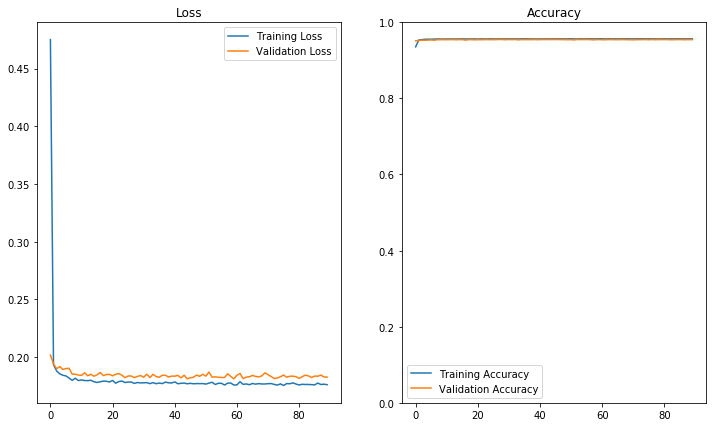

In [52]:
# 視覺化訓練過程
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.figure(figsize=(12, 7))

# 繪製 Training loss 和 Validation loss
plt.subplot(121)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Loss')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(122)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.ylim((0, 1))
plt.legend(loc='best')
plt.title('Accuracy')

plt.show()

In [53]:
testX_ = dfTestData.iloc[:, :]
testX = testX_.values 

In [54]:
y_scaled = scaler.fit_transform(testX)
y_pred = model.predict(y_scaled)

In [55]:
print(y_pred[:10,:]) # 預測出來各個類別的機率值

[[9.5836282e-01 4.1637249e-02]
 [9.5400089e-01 4.5999110e-02]
 [9.5794547e-01 4.2054541e-02]
 [9.5960140e-01 4.0398598e-02]
 [9.5545673e-01 4.4543322e-02]
 [7.9604799e-01 2.0395204e-01]
 [9.5537770e-01 4.4622287e-02]
 [9.5982701e-01 4.0172931e-02]
 [5.0675066e-04 9.9949324e-01]
 [9.4969970e-01 5.0300378e-02]]


In [56]:
y_label = np.argmax(y_pred, axis=1) # 取機率值最高的類別當作預測結果
print(y_label[:20])

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [57]:
testDD = pd.read_csv("./sampleSubmission.csv")
AA = testDD.iloc[:,0]
predResultHW = pd.DataFrame({'user_id':AA,'class':y_label})
predResultHW.to_csv("mid_Fraud25.csv", index = 0)